In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from torch.distributions import Categorical

# Actor Network
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)  
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Actor-Critic Training Loop
def actor_critic(actor, critic, episodes, max_steps=200, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    env = gym.make('MountainCar-v0')
    input_size = env.observation_space.shape[0]
    num_actions = env.action_space.n  # 3 actions in MountainCar-v0

    for episode in range(1, episodes + 1):
        state = env.reset()[0]  # Gym v0.21 and later return (state, info)
        ep_return = 0
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state)

            # Actor selects action
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()  # Sample from action distribution

            # Take action and observe next state and reward
            next_state, reward, done, _,_ = env.step(action.item())

            # Critic estimates value function
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state))

            # Calculate TD target and Advantage
            td_target = reward + gamma * next_value * (1 - done)
            advantage = td_target - value

            # Critic update with MSE loss
            critic_loss = F.mse_loss(value, td_target.detach())
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()

            # Actor update
            log_prob = dist.log_prob(action)
            actor_loss = -log_prob * advantage.detach()  # Policy gradient loss
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()

            # Update state, episode return, and step count
            state = next_state
            ep_return += reward
            step_count += 1

        # Record statistics
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)

        # Print episode statistics
        print(f"Episode {episode}: Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")

    env.close()
    return stats

# Create Actor and Critic models
actor = Actor(input_size=2, num_actions=3)  # MountainCar has 2 states, 3 possible actions
critic = Critic(input_size=2)

# Train the model
stats = actor_critic(actor, critic, episodes=1000)


Episode 1: Actor Loss: -0.8864, Critic Loss: 0.7946, Return: -200.0, Steps: 200
Episode 2: Actor Loss: -1.1002, Critic Loss: 0.6628, Return: -200.0, Steps: 200
Episode 3: Actor Loss: -0.5890, Critic Loss: 0.3602, Return: -200.0, Steps: 200
Episode 4: Actor Loss: -1.6607, Critic Loss: 1.1800, Return: -200.0, Steps: 200
Episode 5: Actor Loss: 0.2698, Critic Loss: 0.0966, Return: -200.0, Steps: 200
Episode 6: Actor Loss: -0.5168, Critic Loss: 0.3498, Return: -200.0, Steps: 200
Episode 7: Actor Loss: -0.9440, Critic Loss: 0.1735, Return: -200.0, Steps: 200
Episode 8: Actor Loss: -0.5815, Critic Loss: 0.1868, Return: -200.0, Steps: 200
Episode 9: Actor Loss: -0.7314, Critic Loss: 0.0650, Return: -200.0, Steps: 200
Episode 10: Actor Loss: 0.0425, Critic Loss: 0.0652, Return: -200.0, Steps: 200
Episode 11: Actor Loss: -0.0179, Critic Loss: 0.0140, Return: -200.0, Steps: 200
Episode 12: Actor Loss: -0.0348, Critic Loss: 0.2172, Return: -200.0, Steps: 200
Episode 13: Actor Loss: -0.0566, Critic

KeyboardInterrupt: 

In [10]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Actor Network
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Actor-Critic Algorithm
def actor_critic(actor, critic, episodes, max_steps=2000, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    env = gym.make('Blackjack-v1')  # Blackjack-v1 kullanıyoruz
    input_size = 3  # Player's sum, dealer's showing card, usable ace
    num_actions = env.action_space.n  # 2 actions: hit (0), stand (1)

    for episode in range(1, episodes + 1):
        state = env.reset()  # BlackJack env reset, state bir tuple olabilir
        state = state[0]  # Sadece ilk öğeyi alıyoruz (state)
        ep_return = 0
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state)
            
            # Actor selects action
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()
            
            # Take action and observe next state and reward
            next_state, reward, done, _,_ = env.step(action.item())
            
            # Critic estimates value function
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state))
            
            # Calculate TD target and Advantage
            td_target = reward + gamma * next_value * (1 - done)
            advantage = td_target - value
            
            # Critic update with MSE loss
            critic_loss = F.mse_loss(value, td_target.detach())
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()
            
            # Actor update
            log_prob = dist.log_prob(action)
            actor_loss = -log_prob * advantage.detach()
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()
            
            # Update state, episode return, and step count
            state = next_state
            ep_return += reward
            step_count += 1

        # Record statistics
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)

        # Print episode statistics
        print(f"Episode {episode}: Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")

    env.close()
    return stats

# Define the networks and train
actor = Actor(input_size=3, num_actions=2)
critic = Critic(input_size=3)
stats = actor_critic(actor, critic, episodes=1000)


Episode 1: Actor Loss: -0.3069, Critic Loss: 0.3965, Return: -1.0, Steps: 1
Episode 2: Actor Loss: -0.0811, Critic Loss: 0.1155, Return: -1.0, Steps: 1
Episode 3: Actor Loss: 3.0512, Critic Loss: 6.0979, Return: 1.0, Steps: 2
Episode 4: Actor Loss: 2.7592, Critic Loss: 5.1611, Return: 1.0, Steps: 1
Episode 5: Actor Loss: 0.2808, Critic Loss: 0.0584, Return: -1.0, Steps: 1
Episode 6: Actor Loss: -0.0108, Critic Loss: 0.0004, Return: -1.0, Steps: 2
Episode 7: Actor Loss: -0.2548, Critic Loss: 0.1620, Return: -1.0, Steps: 1
Episode 8: Actor Loss: -0.0611, Critic Loss: 0.2253, Return: -1.0, Steps: 1
Episode 9: Actor Loss: -0.0926, Critic Loss: 0.1215, Return: -1.0, Steps: 1
Episode 10: Actor Loss: -0.1251, Critic Loss: 0.1581, Return: -1.0, Steps: 1
Episode 11: Actor Loss: -0.0521, Critic Loss: 0.1324, Return: -1.0, Steps: 1
Episode 12: Actor Loss: -0.1950, Critic Loss: 0.1907, Return: -1.0, Steps: 1
Episode 13: Actor Loss: 0.1654, Critic Loss: 0.6884, Return: 0.0, Steps: 1
Episode 14: Act

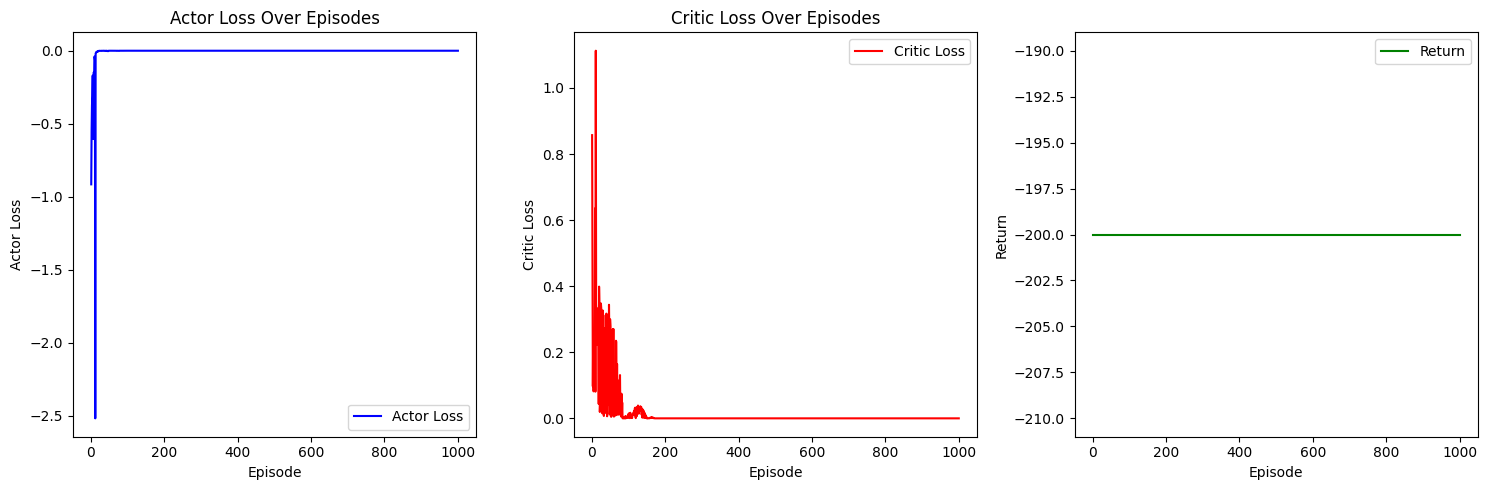

In [9]:
import matplotlib.pyplot as plt

# Actor Loss, Critic Loss ve Return grafiği çizme
def plot_training_stats(stats):
    episodes = range(1, len(stats['Actor Loss']) + 1)
    
    # Actor Loss Grafiği
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episodes, stats['Actor Loss'], label="Actor Loss", color="blue")
    plt.xlabel("Episode")
    plt.ylabel("Actor Loss")
    plt.title("Actor Loss Over Episodes")
    plt.legend()

    # Critic Loss Grafiği
    plt.subplot(1, 3, 2)
    plt.plot(episodes, stats['Critic Loss'], label="Critic Loss", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Critic Loss")
    plt.title("Critic Loss Over Episodes")
    plt.legend()

    # Return Grafiği
    plt.subplot(1, 3, 3)
    plt.plot(episodes, stats['Returns'], label="Return", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Return")
   
    plt.legend()

    plt.tight_layout()
    plt.show()

# Eğitim tamamlandıktan sonra stats'ı kullanarak grafikleri çizdirin
plot_training_stats(stats)